# Project 2- H5N1 Outbreak Prediction (Classification Model)

### *Research Question:*

#### Did a H5N1 outbreak occur at a specific location and time?

In [175]:
# Initial imports
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
# Needed for decision tree visualization
import pydotplus
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns

# Data Preparation & Cleaning

In [176]:
# Read the datasets

wildbirds = pd.read_csv("../Data/hpai-wild-birds.csv")
wildbirds = wildbirds.rename(columns={'Date Detected': 'Outbreak Date'})
wildbirds_df = wildbirds[wildbirds['HPAI Strain'].str.contains('H5N1', na=False)]
wildbirds_df.head()

,State,County,Collection Date,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,Alabama,Limestone,2/5/2022,2/23/2022,EA H5N1,American wigeon,Wild bird,Hunter harvest,NWDP
1,Alabama,Montgomery,10/29/2022,11/7/2022,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,NWDP
2,Alabama,Montgomery,10/29/2022,11/7/2022,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,NWDP
3,Alabama,Montgomery,10/29/2022,11/7/2022,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,NWDP
4,Alabama,Montgomery,10/29/2022,11/7/2022,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,NWDP


In [177]:
wildbirds_df = wildbirds_df.drop(columns = ['Submitting Agency','Sampling Method','Collection Date'])
wildbirds_df=wildbirds_df.dropna(subset='Outbreak Date')
wildbirds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification
0,Alabama,Limestone,2/23/2022,EA H5N1,American wigeon,Wild bird
1,Alabama,Montgomery,11/7/2022,EA/AM H5N1,Black vulture,Wild bird
2,Alabama,Montgomery,11/7/2022,EA/AM H5N1,Black vulture,Wild bird
3,Alabama,Montgomery,11/7/2022,EA/AM H5N1,Black vulture,Wild bird
4,Alabama,Montgomery,11/7/2022,EA/AM H5N1,Black vulture,Wild bird


In [178]:
# Function to convert Date to Day, Month and Year

def convert_date(date):
    return pd.Series([date.year, date.month, date.day], index=["year", "month", "day"])


In [179]:
wildbirds_df["Outbreak Date"] = pd.to_datetime(wildbirds_df["Outbreak Date"],errors='coerce')
wildbirds_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9914 entries, 0 to 11624
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                9914 non-null   object        
 1   County               9914 non-null   object        
 2   Outbreak Date        9914 non-null   datetime64[ns]
 3   HPAI Strain          9914 non-null   object        
 4   Bird Species         9914 non-null   object        
 5   WOAH Classification  9914 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 542.2+ KB


In [180]:
# Convert Wild life Outbreak date to Day, Year and Month

wildbirds_df[['Year','Month','Day']]=wildbirds_df['Outbreak Date'].apply(convert_date)
wildbirds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Year,Month,Day
0,Alabama,Limestone,2022-02-23,EA H5N1,American wigeon,Wild bird,2022,2,23
1,Alabama,Montgomery,2022-11-07,EA/AM H5N1,Black vulture,Wild bird,2022,11,7
2,Alabama,Montgomery,2022-11-07,EA/AM H5N1,Black vulture,Wild bird,2022,11,7
3,Alabama,Montgomery,2022-11-07,EA/AM H5N1,Black vulture,Wild bird,2022,11,7
4,Alabama,Montgomery,2022-11-07,EA/AM H5N1,Black vulture,Wild bird,2022,11,7


In [181]:
# Read US counties dataset
us_county_fips=pd.read_csv("../Data/US_Counties.csv")
us_county_fips=us_county_fips.rename(columns={'state_name':'State',"county":"County","county_fips":"FIPS Code","lat":"Latitude","lng":"Longitude"})
us_county_fips=us_county_fips.drop(columns=['state_id','population'])

us_county_fips.head()

,State,County,FIPS Code,Latitude,Longitude
0,Alabama,Autauga,1001,32.5349,-86.6427
1,Alabama,Baldwin,1003,30.7277,-87.7226
2,Alabama,Barbour,1005,31.8696,-85.3932
3,Alabama,Bibb,1007,32.9986,-87.1265
4,Alabama,Blount,1009,33.9809,-86.5674


In [182]:
us_county_fips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      3144 non-null   object 
 1   County     3144 non-null   object 
 2   FIPS Code  3144 non-null   int64  
 3   Latitude   3144 non-null   float64
 4   Longitude  3144 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 122.9+ KB


In [183]:
# Read Bird Migration dataset

#bird_migrate_df=pd.read_csv("../Data/bird_migration.csv")
#bird_migrate_df.head()

In [184]:
# Dispplay bird migration types
#bird_migrate_df.info()

In [185]:
# Read the weather dataset for adding temperature and Precipitation features

weather_df=pd.read_csv("../Data/weather_cleaned.csv")
weather_df.head()

,State,County,Temp,Precipitation
0,Alabama,Autauga,65.9,52.43
1,Alabama,Baldwin,68.7,60.71
2,Alabama,Barbour,66.4,55.97
3,Alabama,Bibb,64.5,46.88
4,Alabama,Blount,63.1,47.63


In [186]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   State          3107 non-null   object 
 1   County         3107 non-null   object 
 2   Temp           3107 non-null   float64
 3   Precipitation  3107 non-null   float64
dtypes: float64(2), object(2)
memory usage: 97.2+ KB


In [187]:
# Reading the mammals outbreak datasets
mammal_df = pd.read_csv("../Data/HPAI Detections in Mammals.csv")
mammal_df = mammal_df.rename(columns={'Date Detected':'Outbreak Date','Species':'Mammal Species'})
mammal_df = mammal_df[mammal_df['HPAI Strain'].str.contains('H5N1', na=False)]
mammal_df["Outbreak Date"] = pd.to_datetime(mammal_df["Outbreak Date"],errors='coerce')
mammal_df=mammal_df.drop(columns=['Date Collected'])
mammal_df.head()

,State,County,Outbreak Date,HPAI Strain,Mammal Species
0,Oregon,Multnomah,2025-02-10,EA H5N1,Domestic cat
1,Montana,Flathead,2025-02-10,EA AM H5N1,Domestic cat
3,Colorado,Douglas,2025-01-31,EA H5N1,Domestic cat
13,California,Los Angeles,2025-01-15,EA H5N1,Domestic cat
14,California,Los Angeles,2025-01-15,EA H5N1,Domestic cat


In [188]:
# Read mammal df data types
mammal_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 0 to 492
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   State           456 non-null    object        
 1   County          456 non-null    object        
 2   Outbreak Date   456 non-null    datetime64[ns]
 3   HPAI Strain     456 non-null    object        
 4   Mammal Species  456 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 21.4+ KB


In [189]:
# Reading he backyardflock datasets

backyardflock = pd.read_csv("../Data/backyard_flock_old.csv")
backyardflock = backyardflock.rename(columns={'Outbreak Date': 'Outbreak Date'})
backyardflock["Outbreak Date"] = pd.to_datetime(backyardflock["Outbreak Date"],errors='coerce')
#backyardflock=backyardflock.drop(columns=['FullGeoName','FIPS Codes'])
backyardflock.head()

,County,State,Outbreak Date,Flock Type,Flock Size
0,Ottawa,Michigan,2024-12-31,Commercial Turkey Meat Bird,29400
1,Riverside,California,2024-12-31,Commercial Table Egg Layer,181300
2,Spartanburg,South Carolina,2024-12-31,Commercial Upland Gamebird Producer,920
3,Butte,California,2024-12-31,WOAH Non-Poultry,70
4,Miner,South Dakota,2024-12-31,WOAH Poultry,1500


In [190]:
backyardflock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   County         1554 non-null   object        
 1   State          1554 non-null   object        
 2   Outbreak Date  1554 non-null   datetime64[ns]
 3   Flock Type     1554 non-null   object        
 4   Flock Size     1554 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 60.8+ KB


In [191]:
# Combine us county fips df with wild birds

merge_df1=wildbirds_df.merge(us_county_fips,on=['State','County'], how='outer')
#merge_df1=merge_df1.merge(bird_migrate_df,on=['Month','Day','Year'], how='outer')
merge_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11912 entries, 0 to 11911
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                11912 non-null  object        
 1   County               11912 non-null  object        
 2   Outbreak Date        9935 non-null   datetime64[ns]
 3   HPAI Strain          9935 non-null   object        
 4   Bird Species         9935 non-null   object        
 5   WOAH Classification  9935 non-null   object        
 6   Year                 9935 non-null   float64       
 7   Month                9935 non-null   float64       
 8   Day                  9935 non-null   float64       
 9   FIPS Code            11807 non-null  float64       
 10  Latitude             11807 non-null  float64       
 11  Longitude            11807 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 1.1+ MB


In [192]:
merge_df1.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226


In [193]:
# Merge the combined dataframe with backyard flock dataframe
merge_df2=merge_df1.merge(backyardflock,on=['State','County','Outbreak Date'], how='outer')
merge_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13448 entries, 0 to 13447
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                13448 non-null  object        
 1   County               13448 non-null  object        
 2   Outbreak Date        11471 non-null  datetime64[ns]
 3   HPAI Strain          9946 non-null   object        
 4   Bird Species         9946 non-null   object        
 5   WOAH Classification  9946 non-null   object        
 6   Year                 9946 non-null   float64       
 7   Month                9946 non-null   float64       
 8   Day                  9946 non-null   float64       
 9   FIPS Code            11818 non-null  float64       
 10  Latitude             11818 non-null  float64       
 11  Longitude            11818 non-null  float64       
 12  Flock Type           1584 non-null   object        
 13  Flock Size           1584 non-n

In [194]:
merge_df2.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN


In [195]:
# Merge mammals data to the merged dataframe
merge_df3=merge_df2.merge(mammal_df,on=['State','County','Outbreak Date'], how='outer')
merge_df3.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN


In [196]:
merge_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14716 entries, 0 to 14715
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                14716 non-null  object        
 1   County               14716 non-null  object        
 2   Outbreak Date        12739 non-null  datetime64[ns]
 3   HPAI Strain_x        10870 non-null  object        
 4   Bird Species         10870 non-null  object        
 5   WOAH Classification  10870 non-null  object        
 6   Year                 10870 non-null  float64       
 7   Month                10870 non-null  float64       
 8   Day                  10870 non-null  float64       
 9   FIPS Code            12742 non-null  float64       
 10  Latitude             12742 non-null  float64       
 11  Longitude            12742 non-null  float64       
 12  Flock Type           1584 non-null   object        
 13  Flock Size           1584 non-n

In [197]:
# Merge weather data to the dataframe
merge_df4=merge_df3.merge(weather_df,on=['State','County'], how='left')
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
# Fill the missing temperature and precipitation rows with mean values


merge_df4['Temp'] = merge_df4.groupby(['State', 'County'])['Temp'].ffill().bfill()
merge_df4['Precipitation'] = merge_df4.groupby(['State', 'County'])['Precipitation'].ffill().bfill()

    
   
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,58.7,25.03
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03


In [199]:
# Display the merged dataframe types
merge_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14716 entries, 0 to 14715
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                14716 non-null  object        
 1   County               14716 non-null  object        
 2   Outbreak Date        12739 non-null  datetime64[ns]
 3   HPAI Strain_x        10870 non-null  object        
 4   Bird Species         10870 non-null  object        
 5   WOAH Classification  10870 non-null  object        
 6   Year                 10870 non-null  float64       
 7   Month                10870 non-null  float64       
 8   Day                  10870 non-null  float64       
 9   FIPS Code            12742 non-null  float64       
 10  Latitude             12742 non-null  float64       
 11  Longitude            12742 non-null  float64       
 12  Flock Type           1584 non-null   object        
 13  Flock Size           1584 non-n

### Select Target Variable

#### Define a positive case (Outbreak =1)
    If an H5N1 outbreak was recorder at a give state, county and date, label it as 1.
#### Define a Negative case (Outbreak =0)
    For locations and times where no outbreak was recorder, assign 0.

In [200]:
# Create target column for Outbreak data


merge_df4['Outbreak Occured'] = merge_df4['Outbreak Date'].notna().astype(int)
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Outbreak Occured
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,58.7,25.03,0
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1


In [201]:
# Check the value counts of target column "Outbreak occured"
merge_df4['Outbreak Occured'].value_counts()

Outbreak Occured
1    12739
0     1977
Name: count, dtype: int64

In [202]:
# change the Outbreak date column to year, month and day
merge_df4[['Year','Month','Day']]=merge_df4['Outbreak Date'].apply(convert_date)

merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Outbreak Occured
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,58.7,25.03,0
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1


In [203]:
merge_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14716 entries, 0 to 14715
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                14716 non-null  object        
 1   County               14716 non-null  object        
 2   Outbreak Date        12739 non-null  datetime64[ns]
 3   HPAI Strain_x        10870 non-null  object        
 4   Bird Species         10870 non-null  object        
 5   WOAH Classification  10870 non-null  object        
 6   Year                 12739 non-null  float64       
 7   Month                12739 non-null  float64       
 8   Day                  12739 non-null  float64       
 9   FIPS Code            12742 non-null  float64       
 10  Latitude             12742 non-null  float64       
 11  Longitude            12742 non-null  float64       
 12  Flock Type           1584 non-null   object        
 13  Flock Size           1584 non-n

# Data Encoding

In [204]:
# Encoding the categorical columns to numerical data
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Fit and transform categorical columns
categorical_cols = ['State', 'County', 'HPAI Strain_x','HPAI Strain_y','Flock Type', 'Bird Species', 'WOAH Classification','Mammal Species']

for col in categorical_cols:
    merge_df4[col] = encoder.fit_transform(merge_df4[col])


merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Outbreak Occured
0,0,85,NaT,5,219,3,NaN,NaN,NaN,1001.0,32.5349,-86.6427,23,NaN,2,37,58.7,25.03,0
1,0,92,2023-03-01,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,NaN,2,37,58.7,25.03,1
2,0,92,2023-03-01,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,NaN,2,37,58.7,25.03,1
3,0,92,2023-03-01,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,NaN,2,37,58.7,25.03,1
4,0,92,2023-03-01,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,NaN,2,37,58.7,25.03,1


In [205]:
# dipaly the merged dataframe
merge_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14716 entries, 0 to 14715
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                14716 non-null  int32         
 1   County               14716 non-null  int32         
 2   Outbreak Date        12739 non-null  datetime64[ns]
 3   HPAI Strain_x        14716 non-null  int32         
 4   Bird Species         14716 non-null  int32         
 5   WOAH Classification  14716 non-null  int32         
 6   Year                 12739 non-null  float64       
 7   Month                12739 non-null  float64       
 8   Day                  12739 non-null  float64       
 9   FIPS Code            12742 non-null  float64       
 10  Latitude             12742 non-null  float64       
 11  Longitude            12742 non-null  float64       
 12  Flock Type           14716 non-null  int32         
 13  Flock Size           1584 non-n

In [206]:
# Handle missing values

merge_df4=merge_df4.fillna(0) # Replace all NaN with 0
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Outbreak Occured
0,0,85,0,5,219,3,0.0,0.0,0.0,1001.0,32.5349,-86.6427,23,0.0,2,37,58.7,25.03,0
1,0,92,2023-03-01 00:00:00,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,0.0,2,37,58.7,25.03,1
2,0,92,2023-03-01 00:00:00,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,0.0,2,37,58.7,25.03,1
3,0,92,2023-03-01 00:00:00,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,0.0,2,37,58.7,25.03,1
4,0,92,2023-03-01 00:00:00,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,0.0,2,37,58.7,25.03,1


In [207]:
# Rename the strains column names

merge_df4=merge_df4.rename(columns={'HPAI Strain_x': 'HPAI Wildbird Strain', 'HPAI Strain_y': 'HPAI Flock Strain'})

# Remove the outbreak date column as it is already convered to Year, Month, Day columns
encoded_df=merge_df4.drop(columns=['Outbreak Date'])
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14716 entries, 0 to 14715
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   State                 14716 non-null  int32  
 1   County                14716 non-null  int32  
 2   HPAI Wildbird Strain  14716 non-null  int32  
 3   Bird Species          14716 non-null  int32  
 4   WOAH Classification   14716 non-null  int32  
 5   Year                  14716 non-null  float64
 6   Month                 14716 non-null  float64
 7   Day                   14716 non-null  float64
 8   FIPS Code             14716 non-null  float64
 9   Latitude              14716 non-null  float64
 10  Longitude             14716 non-null  float64
 11  Flock Type            14716 non-null  int32  
 12  Flock Size            14716 non-null  float64
 13  HPAI Flock Strain     14716 non-null  int32  
 14  Mammal Species        14716 non-null  int32  
 15  Temp               

In [208]:
# Correlation map
correlation_df=encoded_df.drop(columns=['State','County','FIPS Code','WOAH Classification','Day','Year'])
correlation_df.corr()

,HPAI Wildbird Strain,Bird Species,Month,Latitude,Longitude,Flock Type,Flock Size,HPAI Flock Strain,Mammal Species,Temp,Precipitation,Outbreak Occured
HPAI Wildbird Strain,1.000000,0.584487,-0.363364,-0.477961,0.482554,-0.318756,0.101026,0.054220,0.108051,0.007319,0.021615,-0.521423
Bird Species,0.584487,1.000000,-0.311850,-0.424629,0.413614,-0.301742,0.098524,-0.070921,-0.034870,-0.003031,-0.004564,-0.484636
Month,-0.363364,-0.311850,1.000000,-0.001550,-0.035097,-0.035700,0.007144,0.048432,0.044757,-0.015269,-0.000513,0.587905
Latitude,-0.477961,-0.424629,-0.001550,1.000000,-0.893763,0.565038,-0.182696,0.200349,0.147426,-0.098679,-0.124145,-0.075674
Longitude,0.482554,0.413614,-0.035097,-0.893763,1.000000,-0.552565,0.176947,-0.102683,-0.035488,0.028716,0.012291,0.081203
Flock Type,-0.318756,-0.301742,-0.035700,0.565038,-0.552565,1.000000,-0.384409,-0.077261,-0.075965,-0.019704,0.017021,-0.099942
Flock Size,0.101026,0.098524,0.007144,-0.182696,0.176947,-0.384409,1.000000,0.025184,0.024762,0.015487,0.015070,0.032577
HPAI Flock Strain,0.054220,-0.070921,0.048432,0.200349,-0.102683,-0.077261,0.025184,1.000000,0.891839,-0.018174,0.002986,-0.119972
Mammal Species,0.108051,-0.034870,0.044757,0.147426,-0.035488,-0.075965,0.024762,0.891839,1.000000,-0.041224,-0.023985,-0.117960
Temp,0.007319,-0.003031,-0.015269,-0.098679,0.028716,-0.019704,0.015487,-0.018174,-0.041224,1.000000,0.751536,-0.065245


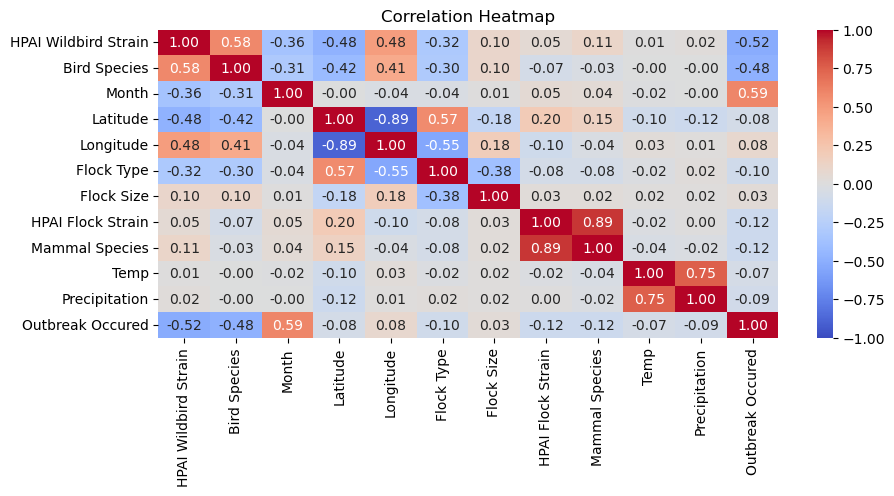

In [209]:
# Plot the correlation

plt.figure(figsize=(10, 4))
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Key Observations from the Correlation Matrix:
Outbreak Risk has the highest correlation with Month (0.59), indicating that the month (likely seasonality) plays a significant role in predicting the outbreaks.

Flock Type and Latitude have a moderate positive correlation (0.57), indicating that certain types of flocks might be located at specific latitudes.

There is a very weak correlation between the mammals and the flock type or bird species indicating less possibility of transmission between them. 

The HPAI Strain_x (Wild bird strain) has a moderate positive correlation with the Latitude which means certain bird species are specific to that latitude. 



# Data Splitting

In [210]:
# Split the training testing data
X=correlation_df.copy().drop(columns='Outbreak Occured')
y=correlation_df['Outbreak Occured']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.3)

In [211]:
X_train.shape

(10301, 11)

In [212]:
X_test.shape

(4415, 11)

# Data Scaling

In [213]:
# Use Standard Scaler for scaling the numerical data

scaler=StandardScaler()
X_train_scaled =scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)
X_train_scaled

array([[ 1.32253716,  1.22977365,  1.35164988, ...,  0.29848374,
         0.16369563, -0.40557267],
       [-1.09863567, -0.08976544,  0.63987092, ...,  0.29848374,
        -3.34401472, -1.6174545 ],
       [-1.09863567, -1.32851642,  1.11439023, ...,  0.29848374,
         0.18759825, -0.03033958],
       ...,
       [-1.09863567, -1.05922272, -0.07190803, ...,  0.29848374,
        -0.26057598, -1.02289162],
       [ 0.35406803, -0.00897733,  0.87713057, ...,  0.29848374,
         0.16369563, -0.40557267],
       [-1.09863567,  0.74504501, -0.78368699, ...,  0.29848374,
        -0.26057598, -1.02289162]])

# Model and fit the data to Logistic regression

In [214]:
# Build logistic regression model

from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_scaled, y_train)


LogisticRegression()

In [215]:
# Score the model
print(f"Training Data Score: {logistic_regression_model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {logistic_regression_model.score(X_test_scaled, y_test)}")

Training Data Score: 1.0
Testing Data Score: 1.0


# Random Forest model

In [216]:
# Train a Random Forest model

from sklearn.ensemble import RandomForestClassifier

rf_model=RandomForestClassifier(random_state=1,n_estimators=500).fit(X_train_scaled,y_train)

In [217]:
# Evaluate the model
print(f'Training Score: {rf_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {rf_model.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 1.0


In [218]:
# Get the feature importance array
feature_importances = rf_model.feature_importances_

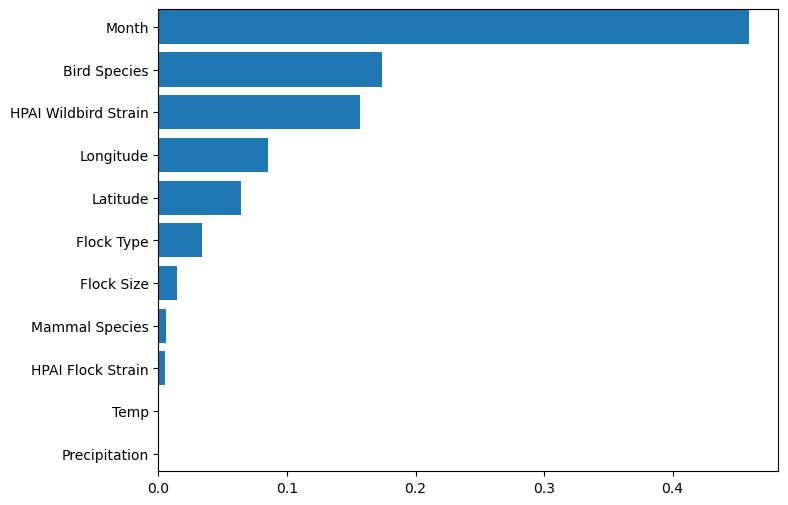

In [219]:
# Plot the feature importances
features = sorted(zip(X.columns, feature_importances), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(8,6)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [220]:
# Import an Extremely Random Trees classifier
from sklearn.ensemble import ExtraTreesClassifier

In [221]:
# Train the ExtraTreesClassifier model
etc_model = ExtraTreesClassifier(random_state=1).fit(X_train_scaled, y_train)

# Evaluate the model
print(f'Training Score: {etc_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {etc_model.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 1.0


In [222]:
# Import Gradient Boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

In [223]:
gbc_model=GradientBoostingClassifier(random_state=1).fit(X_train_scaled,y_train)

# Evaluate the model
print(f'Training Score: {gbc_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {gbc_model.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 1.0
